# Предсказание цен на недвижимость

In [23]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from cycler import cycler

In [24]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error

### Признаки ###

 - CRIM - количество преступлений на душу населения
 - ZN - процент жилых участков площадью больше 25 тыс. кв. футов (~ 23 сотки)
 - INDUS - процент площадей под оптовую торговлю
 - CHAS - протекает ли река
 - NOX - концентрация оксидов азота
 - RM - среднее число комнат в здании
 - AGE - доля зданий, построенных до 1940 года
 - DIS - взвешенное расстояние до 5 деловых центров Бостона
 - RAD - индекс доступности скоростных магистралей
 - TAX - уровень налогов
 - PTRATIO - среднее число учащихся на одного преподавателя
 - B - процент афроамериканцев
 - LSTAT - процент граждан с низким уровнем жизни
 - MEDV (целевой) - медианная стоимости домов в районе

### Загрузка данных

In [25]:
boston = load_boston()

In [26]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [27]:
X, y = boston['data'], boston['target']
print(X.shape, y.shape)

(506, 13) (506,)


### Разделение данных на train/test

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
print('Train size: ', X_train.shape[0], 'Test size: ', X_valid.shape[0])

Train size:  404 Test size:  102


### Визуальная проверка равенства распределений цены

Если мы в тренировочную выборку попадут примеры домов с очень низкой ценой, а тестировать модель мы будем на домах с высокой ценой, нас ждет неудача. Ошибка будет большой, а модель бесполезной, поэтому данные надо разделять так чтобы распределение целевой переменной(цены в нашем случае) совпадало в трейн и тест выборках.

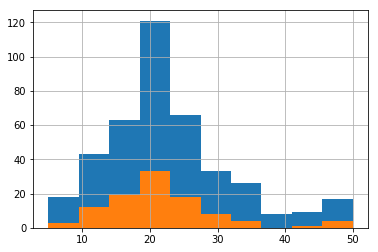

In [29]:
pd.Series(y_train).hist()
pd.Series(y_valid).hist()

#### [Задача 1]. 
#### Обучить модель линейной регрессии на train, сделать предсказание на test. Посчитать среднеквадратичную ошибку(MSE).

In [30]:
clf = LinearRegression(fit_intercept=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
mse

24.311426929693297

#### [Задача 2]. 
#### Обучить модель линейной регрессии с регуляризацией(Ridge), посчитать MSE используя процедуру кросс-валидации(CV). Посчитать среднее, медиану и стандартное отклонение. Распечатать на экран веса модели(coef_) и сдвиг(intercept_)

In [57]:
kfold = KFold(n_splits=3)
msearray = []
clf = Ridge()
for train_idx, test_idx in kfold.split(X):
    clf.fit(X[train_idx], y[train_idx])
    y_pred = clf.predict(X[test_idx])
    mse = mean_squared_error(y[test_idx], y_pred)
    msearray.append(mse)

print(np.mean(msearray), np.median(msearray), np.std(msearray))
print(msearray)
print(clf.coef_)
print(clf.intercept_)

109.008813477 33.0021787255 118.832701702
[17.208201421427415, 33.002178725493174, 276.81606028488136]
[ 0.90609735  0.01429039  0.01374678  0.80221516 -3.72705685  9.16260152
 -0.04876767 -0.90383608  0.11133576 -0.01454825 -0.6119898   0.01661435
 -0.1066152 ]
-15.8254813699


In [37]:
tclf = Ridge()

In [60]:
from sklearn.model_selection import cross_val_score
cross_val_score(tclf, X, y, scoring=lambda p, x, y: mean_squared_error(y, p.predict(x)))

array([  17.20820142,   33.00217873,  276.81606028])

In [56]:
dir(cross_val_score)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

#### [Задача 3]. 
#### Подобрать оптимальный параметр ***alpha*** с помощью CV. Распечатать его значение на экран. Затем вычислить MSE на CV для модели с выбранным оптимальным параметром. Вычислить среднее, медиану и стандартное отклонение. Распечатать на экран веса модели(coef_) и сдвиг(intercept_)

In [32]:
clf = RidgeCV(alphas=np.logspace(-2, -6, 200), fit_intercept=True, store_cv_values=True)

In [33]:
clf.fit(X, y)

RidgeCV(alphas=array([  1.00000e-02,   9.54772e-03, ...,   1.04737e-06,   1.00000e-06]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [34]:
mean_squared_error(y, clf.predict(X))

21.89781939107942

In [35]:
print("Alpha:", clf.alpha_)

Alpha: 0.01


In [36]:
kfold = KFold(n_splits=3)
opt_clf = Ridge(alpha=clf.alpha_)
for train_idx, test_idx in kfold.split(X):
    opt_clf.fit(X[train_idx], y[train_idx])
    y_pred = opt_clf.predict(X[test_idx])
    mse = mean_squared_error(y[test_idx], y_pred)
    msearray.append(mse)

print(np.mean(msearray), np.median(msearray), np.std(msearray))
print(msearray)
print(opt_clf.coef_)
print(opt_clf.intercept_)

138.010940038 33.7434866827 165.459434046
[17.208201421427415, 33.002178725493174, 276.81606028488136, 20.550901272949403, 34.484794639876213, 446.00350388497782]
[ 1.22744455  0.01318112  0.02857974  0.76959316 -9.00200497  9.24387694
 -0.04713059 -0.98637035  0.12040362 -0.01431802 -0.64766421  0.01612559
 -0.09080221]
-13.0913766022


#### [Задача 4]. 
#### Нарисовать график изменения весов модели в зависимости от уровня регуляризации(параметра ***alpha***)

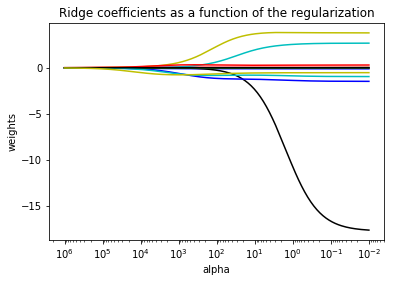

In [15]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

# 4.1 Создать модель Ridge 

# 4.2 Создать пустой массив

# 4.3 - для каждого значения x из списка **ridge_alphas** установить параметр регуляризации модели равным x
#     - обучить модель на всех данных X,y
#     - добавить в массив коэфициенты обученной модели
coefs = []
for a in ridge_alphas:
    rreg = Ridge(alpha=a, fit_intercept=True)
    rreg.fit(X, y)
    coefs.append(rreg.coef_)
ax = plt.gca()
ax.set_prop_cycle(cycler('color', ['b', 'r', 'g', 'c', 'k', 'y', 'm']))
ax.plot(ridge_alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

#### [Задача 5]. 
#### Повторить задачу 2,3,4,5 но для модели Lasso

In [16]:
kfold = KFold(n_splits=3)
msearray = []
clf = Lasso()
for train_idx, test_idx in kfold.split(X):
    clf.fit(X[train_idx], y[train_idx])
    y_pred = clf.predict(X[test_idx])
    mse = mean_squared_error(y[test_idx], y_pred)
    msearray.append(mse)

print(np.mean(msearray), np.median(msearray), np.std(msearray))
print(msearray)
print(clf.coef_)
print(clf.intercept_)

47.8250371427 57.3548779553 18.8962062159
[21.438680276253983, 57.354877955278639, 64.681553196433725]
[ 0.          0.02214845  0.          0.          0.          5.1506894   0.
 -0.45877628  0.         -0.01586085 -0.65451812  0.01338254 -0.44160721]
9.88219048717


In [17]:
clf = LassoCV(alphas=np.logspace(-2, -6, 200), n_jobs=-1)

In [18]:
clf.fit(X, y)

LassoCV(alphas=array([  1.00000e-02,   9.54772e-03, ...,   1.04737e-06,   1.00000e-06]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=-1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [19]:
mean_squared_error(y, clf.predict(X))

21.934333403315506

In [20]:
print("Alpha:", clf.alpha_)

Alpha: 0.01


In [21]:
kfold = KFold(n_splits=3)
opt_clf = Lasso(alpha=clf.alpha_)
for train_idx, test_idx in kfold.split(X):
    opt_clf.fit(X[train_idx], y[train_idx])
    y_pred = opt_clf.predict(X[test_idx])
    mse = mean_squared_error(y[test_idx], y_pred)
    msearray.append(mse)

print(np.mean(msearray), np.median(msearray), np.std(msearray))
print(msearray)
print(opt_clf.coef_)
print(opt_clf.intercept_)

77.4973835878 45.7167836295 87.0142393468
[21.438680276253983, 57.354877955278639, 64.681553196433725, 19.092764359101288, 34.0786893036992, 268.33773643606992]
[ 0.88566969  0.01349027  0.01602385  0.69163106 -3.86001806  9.26164551
 -0.04909826 -0.89764703  0.10495952 -0.01441554 -0.6129584   0.01637184
 -0.09795332]
-16.3824719754


#### [Задача 6]. 
#### Нарисовать график аналогичный задаче 4

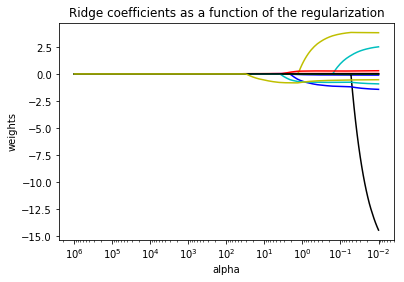

In [22]:
n_alphas = 200
lasso_alphas = np.logspace(-2, 6, n_alphas)
coefs = []
for a in lasso_alphas:
    lreg = Lasso(alpha=a, fit_intercept=True)
    lreg.fit(X, y)
    coefs.append(lreg.coef_)
ax = plt.gca()
ax.set_prop_cycle(cycler('color', ['b', 'r', 'g', 'c', 'k', 'y', 'm']))
ax.plot(lasso_alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

#### [Задача 7]. 
#### Сравнить графики из задачи 4 и задачи 6. Сделать выводы, рассказать их преподавателю :)

При `L1 оптимизации (Lasso)` если `alpha` > ~10 веса вообще не меняются и держатся на нуле, в `L2 (Ridge)` такое происходит только при `alpha` в районе 10^6, при `alpha` = 10^-2 веса одинаковы, следственно при `L1` они изменяются быстрее (после порогвой альфы)